# Competition Kaggle

Comenzamos importando todas las lirerías que hacen falta

In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

Creamos una copia original de la lectura del archivo para no tener que volverla a leer

In [7]:
dfOrig = pd.read_csv('competitionKschool/Train.csv', sep=',', encoding='latin-1')

In [88]:
df = dfOrig.copy()
df.isna().sum()[df.isna().sum() > 0]

cant_ent_deuda_consu_mes00      238796
cant_ent_deuda_consu_mes01      242562
cant_ent_deuda_consu_mes02      245575
cant_ent_deuda_consu_mes03      248653
cant_ent_deuda_consu_mes04      251079
cant_ent_deuda_consu_mes05      254027
cant_ent_deuda_hipot_mes00      238796
cant_ent_deuda_hipot_mes01      242562
cant_ent_deuda_hipot_mes02      245575
cant_ent_deuda_hipot_mes03      248653
cant_ent_deuda_hipot_mes04      251079
cant_ent_deuda_hipot_mes05      254027
cant_prot_no_aclarados_soles      2461
codigo_rubro_actividad          228651
deuda_dir_vig_consu_mes00       330583
deuda_dir_vig_consu_mes01       333531
deuda_dir_vig_consu_mes02       336109
deuda_dir_vig_consu_mes03       338259
deuda_dir_vig_consu_mes04       340243
deuda_dir_vig_consu_mes05       342107
edad                             21298
monto_doc_morosos_soles           2461
risk_predictor_2                  7771
rubro_actividades               228651
situacion_contribuyente         228486
tipo_sociedad            

### Primera lectura

Realizamos los primeros mapeos de los campos

In [89]:
df['target'].value_counts(normalize=True)

## Diccionario direccion_eval
dicc_direccion_eval = {'mala':0, 'regular':1, 'normal':2, 'buena':3}
df['direccion_eval'] = df['direccion_eval'].map(dicc_direccion_eval)

## dicc_reportado
reportadoList = ['esta_reportado_mes00', 'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03', 'esta_reportado_mes04', 'esta_reportado_mes05']
dicc_reportado = {'No identificado':-1, 'No':0, 'Si':1}
for column in reportadoList:
    df[column] = df[column].map(dicc_reportado)
df['esta_reportado'] = (df['esta_reportado_mes00'] == -1).astype(int)

## dicc_rango_ingresos_2
dicc_rango_ingresos_2 = {'No identificado' : -1, 'Sin ingreso' : 0, '< 450' : 450, '<450' : 450, '[450 - 600>' : 600, '[450-600>' : 600, '[600 - 1,000>' : 1000, '[600-1,000>' : 1000, '[1,000 - 1,300>' : 1300, '[1,000-1,300>' : 1300, '[1,300 - 2,000>' : 2000, '[1,300-2,000>' : 2000, '[2,000 - 3,500>' : 3500, '[2,000-3,500>' : 3500, '[3,500 - 6,000>' : 6000, '[3,500-6,000>' : 6000, '[6,000 - 10,000>' : 10000, '[6,000-10,000>' : 10000, '>=10,000' : 15000}
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(dicc_rango_ingresos_2)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(lambda x: x if x >-1 else 1300)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)

## cantidad_doc_morosos
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].map(lambda x: x if x != 'No identificado' else 0)
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].astype(int)

## edad 
df['edad'] = df['edad'].fillna(18)

## tipo_sociedad 
df['tipo_sociedad'] = df['tipo_sociedad'].fillna('empty')


## cant_ent_deuda_ consu_hipot _mes
list_consu = filter_columns(df, 'cant_ent_deuda_consu')
for name_consu in list_consu:
    name_column_na = name_consu.replace('consu', 'consu_hipot_null')
    df[name_column_na] = df[name_consu].isna().astype(int)
    df[name_hipot] = df[name_consu].fillna(0)
    name_hipot = name_consu.replace('consu', 'hipot')
    df[name_hipot] = df[name_hipot].fillna(0)

In [90]:
df.isna().sum()[df.isna().sum() > 0]

cant_ent_deuda_consu_mes00      238796
cant_ent_deuda_consu_mes01      242562
cant_ent_deuda_consu_mes02      245575
cant_ent_deuda_consu_mes03      248653
cant_ent_deuda_consu_mes04      251079
cant_ent_deuda_consu_mes05      254027
cant_prot_no_aclarados_soles      2461
codigo_rubro_actividad          228651
deuda_dir_vig_consu_mes00       330583
deuda_dir_vig_consu_mes01       333531
deuda_dir_vig_consu_mes02       336109
deuda_dir_vig_consu_mes03       338259
deuda_dir_vig_consu_mes04       340243
deuda_dir_vig_consu_mes05       342107
monto_doc_morosos_soles           2461
risk_predictor_2                  7771
rubro_actividades               228651
situacion_contribuyente         228486
tipo_sociedad                   228486
dtype: int64

## Model

In [82]:
train, test = train_test_split(df, test_size=0.25, stratify=df['target'], random_state=42)

In [83]:
def dropNullColumns(dfInput):
    dfWithOutNulls = dfInput.isna().sum()
    dfWithOutNulls = dfInput[dfWithOutNulls[dfWithOutNulls == 0].index]
    return dfWithOutNulls

In [84]:
trainTmp = dropNullColumns(train)
categorical_cols = trainTmp.drop('Id', axis = 1).select_dtypes('O').columns
trainTmp = pd.get_dummies(trainTmp, columns=categorical_cols, drop_first=True)
testTmp = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

### RamdomForest

In [85]:
inicio = time.time()
model = RandomForestClassifier(random_state=42)
predictive_variables = [c for c in trainTmp.columns
                       if c not in ('Id', 'target')]
model.fit(trainTmp[predictive_variables], train.target)
probabilities = model.predict_proba(testTmp[predictive_variables])[:, 1]
fin = time.time()
print(fin-inicio)

316.4139606952667


### Choosing the probability threshold

In [86]:
roc_auc_scores = []
for threshold in np.arange(0.01, 1, 0.01):
    predictions = probabilities >= threshold
    roc_auc_scores.append((threshold, roc_auc_score(testTmp.target, predictions)))
max_roc_auc_threshold = sorted(roc_auc_scores, key=lambda x:x[1], reverse=True)[0][0]
predictions = probabilities >= max_roc_auc_threshold
print(f'optimum threshold found: {max_roc_auc_threshold}')
print(roc_auc_score(testTmp.target, predictions))

optimum threshold found: 0.34
0.624224877925331


In [176]:
confusion_matrix(testTmp.target, predictions)


array([[50705, 29861],
       [15629, 25825]])

In [ ]:
#1 Solo con varables no nulas y dummies
#optimum threshold found: 0.36000000000000004
#0.6230363896185201

#2 Solo con varables no nulas y aplicando direccion_eval 
#optimum threshold found: 0.36000000000000004
#0.6229165803362066

#3 Solo con varables no nulas y aplicando direccion_eval y dicc_reportado
#optimum threshold found: 0.36000000000000004
#0.6225590813571202

#4 Incluye rango_ingresos_2 a lo anterior
#optimum threshold found: 0.36000000000000004
#0.6226945635141578

#4 Incluye rcantidad_doc_morosos a lo anterior
# tiempo 360
#optimum threshold found: 0.34
#0.6261697339444241

In [66]:
categorical_cols = trainTmp.select_dtypes('O').columns
trainTmp = pd.get_dummies(trainTmp, columns=categorical_cols, drop_first=True)
trainTmp

MemoryError: Unable to allocate 125. GiB for an array with shape (366057, 366057) and data type uint8

In [4]:
df_tmp = df
df_tmp['num'] = 1
df_tmp = df_tmp.groupby(
   ['risk_predictor_2']
)['target', 'num'].sum()
df_tmp['porct_fraud'] = df_tmp['target']/df_tmp['num']
print(df_tmp.sort_values('risk_predictor_2'))
print(df.isna().sum())

<ipython-input-4-efbd9a39ca11>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tmp = df_tmp.groupby(


                  target  num  porct_fraud
risk_predictor_2                          
1.0                    2    2     1.000000
2.0                    8   11     0.727273
3.0                   23   36     0.638889
4.0                   37   70     0.528571
5.0                   49   75     0.653333
...                  ...  ...          ...
991.0                  7   37     0.189189
992.0                  0   25     0.000000
993.0                  1   16     0.062500
994.0                  0    8     0.000000
995.0                  0    2     0.000000

[995 rows x 3 columns]
Id                                   0
target                               0
calificacion_mes00                   0
calificacion_mes01                   0
calificacion_mes02                   0
calificacion_mes03                   0
calificacion_mes04                   0
calificacion_mes05                   0
canal                                0
cant_ent_deuda_consu_mes00      238796
cant_ent_deuda_consu_mes01 

## Metodhs

### Graphs of barras by value

In [56]:
def printBarrasApiladas(dfApilada , X, normalize=True):
    dfApilada = dfApilada[['target', X]]
    sizeDf = dfApilada.shape[0]
    dfApiladaDummy = pd.get_dummies(dfApilada['target'], prefix="", prefix_sep="")
    dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)
    dfApilada['count'] = 1
    dfApilada = dfApilada.groupby(X, dropna=False).sum().reset_index()
    if normalize == False:
        dfApilada['count'] = 1
    columnNa = -1
    if dfApilada[X].dtypes == 'object':
        dfApilada["sort"] = dfApilada["1"]/dfApilada["count"]
        dfApilada = dfApilada.sort_values('sort')   
        dfApilada = dfApilada.drop(["sort"], axis = 1)
        columnNa = "Nan"
    dfApilada[X] = dfApilada[X].fillna(columnNa)
    dfApiladaSum = np.zeros([dfApilada.shape[0],])
    plt.figure(figsize=(15, 3))
    for i in dfApilada.drop([X, 'target', 'count'], axis = 1):
        plt.bar(dfApilada[X], dfApilada[i]/dfApilada['count'], label = i, bottom = dfApiladaSum)
        dfApiladaSum = dfApiladaSum + np.array(dfApilada[i]/dfApilada['count'])
    plt.title(X)
    plt.legend()
    plt.xticks(rotation=45)

<ipython-input-56-1a041a284e91>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)


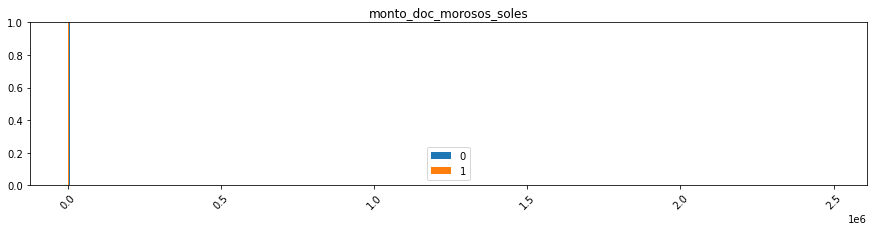

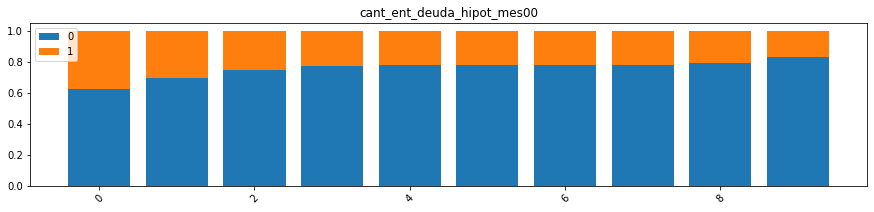

In [92]:
printBarrasApiladas(df, 'monto_doc_morosos_soles', normalize=True)
printBarrasApiladas(df, 'cant_ent_deuda_hipot_mes00', normalize=True)

### Null Relation

In [52]:
def notNullRelation(dfTmp , listColumn):
    dfTmp = dfTmp[listColumn].notna().astype(int)
    num = 1
    dfTmp['sum'] = 0
    for item in dfTmp.drop('sum', axis = 1):
        print(item)
        print(num)
        dfTmp[item] = dfTmp[item]*num
        dfTmp['sum'] = dfTmp['sum'] + dfTmp[item]
        num = num*10
    dfTmp = dfTmp.reset_index()
    print('---------------')
    print(dfTmp['sum'].value_counts())

In [102]:
deudaList = ['esta_reportado_mes00', 'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03', 'esta_reportado_mes04', 'esta_reportado_mes05']
notNullRelation(df , deudaList)

esta_reportado_mes00
1
esta_reportado_mes01
10
esta_reportado_mes02
100
esta_reportado_mes03
1000
esta_reportado_mes04
10000
esta_reportado_mes05
100000
---------------
111111    488077
Name: sum, dtype: int64


### Count Values

In [ ]:
def printCountValues(trainTmp):
    for col in trainTmp.drop('Id', axis = 1):
        print(col)
        print(trainTmp[col].value_counts())
        print('--------------------')

In [74]:
def filter_columns(dfTmp, filter_column):
    list_columns = [column for column in dfTmp.columns if filter_column in column]
    return list_columns

In [75]:
filter_col = filter_columns(df, 'cant_ent_deuda_consu')
print(filter_col)

['cant_ent_deuda_consu_mes00', 'cant_ent_deuda_consu_mes01', 'cant_ent_deuda_consu_mes02', 'cant_ent_deuda_consu_mes03', 'cant_ent_deuda_consu_mes04', 'cant_ent_deuda_consu_mes05']


In [59]:
df['cant_ent_deuda_hipot_mes00'].value_counts()

0.0    237455
1.0     11590
2.0       228
3.0         8
Name: cant_ent_deuda_hipot_mes00, dtype: int64

In [60]:
df['cant_ent_deuda_consu_mes00'].value_counts()

0.0    85835
1.0    84851
2.0    42726
3.0    21539
4.0     9500
5.0     3525
6.0     1027
7.0      224
8.0       48
9.0        6
Name: cant_ent_deuda_consu_mes00, dtype: int64

In [ ]:
df